# **MAC0317/MAC5920**
## Introdução ao Processamento de Sinais Digitais
Exemplos do Capítulo 1 do livro _Discrete Fourier Analysis and Wavelets_ de Broughton e Bryan

In [1]:
# Inclui algumas bibliotecas importantes
import math as m
import sys
import time
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D
import IPython
import IPython.display as ipd
import ipywidgets as ipw
# verifica versão do Python (deve funcionar com >=3.5)
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)


## Exemplos de aplicação
> ### Compressão
>> - economia de espaço e/ou tempo de transmissão
>> - pode ser realizada sem perdas ou com perdas
>> - perdas envolvem alguma noção de "qualidade"
>> - pressupõe algum tipo de análise dos dados

## Exemplos de aplicação
> ### Realce/Restauração
>> - recuperar parte do conteúdo perdido/degradado
>> - melhorias em relação ao original
>> - aumentar resolução/contraste
>> - equalizar/redistribuir componentes
>> - corrigir relação sinal/ruído (ou eliminar ruído)


## Exemplos de aplicação
> ### Análise / Extração de características
>> - detecção (bordas / objetos / eventos de interesse)
>> - classificação
>> - interpretação (visão/escuta computacional)
>> - pode ajudar em outras tarefas (compressão/restauração/etc)

## Métodos baseados em transformadas
> - permitem abordar os dados através de múltiplas perspectivas
> - definem domínios de representação diferentes (tempo/espaço/frequência)
> - facilitam / aceleram certos algoritmos (redução de ruído, multiplicação de polinômios)
> - frequentemente são operadores lineares inversíveis (usam álgebra linear matricial)

# Seção 1.3: Sinais e imagens

## Sinais unidimensionais
> - modelados como funções de uma variável real $t\in[a,b]$ (costuma representar o _tempo_)
> - $f(t)\in\mathbb{R}$ pode representar pressão (sonora), corrente/potencial elétric@, velocidade de um objeto, temperatura, etc. 

### Exemplo (Figura 1.1): Um sinal analógico com duas componentes senoidais

Considere a função do exemplo da página 4

$$ x = 0.75\sin(3t)+0.5\sin(7t), $$

para $t\in[0,4\pi]$

In [2]:
# Cria um domínio temporal entre 0 e 4$\pi$ com 800 amostras/segundo
# (esta é uma amostragem arbitrária, mas que permite plotar/visualizar
# a função "como se fosse contínua")
rate = 800
duration = 4*m.pi
t = np.arange(0,duration,1/rate)

In [3]:
a1, w1 = 0.75, 3
a2, w2 = 0.5, 7
x = a1*np.sin(w1*t) + a2*np.sin(w2*t)

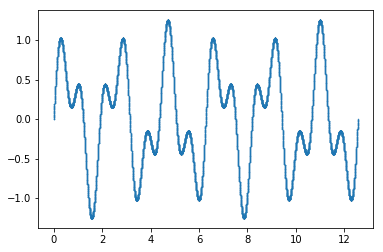

In [4]:
# Mostra o gráfico da função;
# o '.' impede os pontos adjacentes de serem conectados por segmentos de reta;
# markersize (ou ms) regula a largura da linha.
%matplotlib inline
plt.plot(t,x,'.',markersize=1)
plt.show()

#### Figura 1.1: Versão interativa
Selecione manualmente as amplitudes e as frequências angulares das componentes do sinal e veja o resultado

In [5]:
def pltsignal(a1=0.5,w1=3,a2=0.5,w2=7):
    global x
    x = a1*np.sin(w1*t) + a2*np.sin(w2*t)
    %matplotlib inline
    plt.plot(t,x,'.',ms=1)
    plt.show()

In [6]:
ipw.interact(pltsignal, a1=(0,1,0.1), w1=(1,15,0.1), a2=(0,1,0.1), w2=(1,15,0.1))

<function __main__.pltsignal>

### Amostragem temporal

> - passagem do domínio contínuo ($t\in[a,b]$) para domínio discreto ($n=0,1,\ldots,N$)
> - parametrizada pelo intervalo de amostragem ($\Delta_t=\frac{b-a}{N}$) ou taxa de amostragem ($SR=\frac{N}{b-a}$)

> $$x_n = x(a+n\Delta_t) = x\left(a+\frac{n}{SR}\right)$$

> - produz um vetor $x=(x_0,x_1,\ldots,x_N)\in\mathbb{R}^{N+1}$.

### Exemplo/Figura 1.2: Amostragem temporal, quantização e ruído

> - Nesse exemplo é usado o mesmo sinal da Figura 1.1

> - Selecionamos pontos no domínio separados de N em N amostras

In [7]:
def pltsubsampledsignal(N = 100):
    global ts,xs
    ts = t[0:len(t):N]
    xs = x[0:len(x):N]
    %matplotlib inline
    plt.plot(ts,xs,'.',ms=2)
    plt.show()

In [8]:
ipw.interact(pltsubsampledsignal,N=(1,200,10))

<function __main__.pltsubsampledsignal>

**Exemplo adicional:** transpõe o sinal para a faixa audível e toca
- gera D=5 segundos de sinal a 8000 amostras/segundo
- multiplica as frequências por F=1000 para cairem na faixa audível.

>  As frequências originais eram

> $$\frac{3}{2\pi} = 0.477\ \mbox{Hz}$$

> e 

> $$\frac{7}{2\pi} = 1.114\ \mbox{Hz},$$

> assim as novas serão $477$ Hz e $1114$ Hz.

In [9]:
rate=8000
def playsignal(rate=rate,duration=5,factor=1000):
    global X, T
    T = np.arange(0,duration,1/rate)
    X = a1*np.sin(factor*w1*T) + a2*np.sin(factor*w2*T)
    print("frequência 1 =",factor*w1/(2*m.pi))
    print("frequência 2 =",factor*w2/(2*m.pi))
    ipd.display(ipd.Audio(X, rate=rate))

In [10]:
ipw.interact(playsignal,rate=ipw.fixed(rate),duration=(0.1,5,0.1),factor=(100,10000,100))

<function __main__.playsignal>

### Quantização

**Alternativa à Fig. 1.2:** sinal amostrado com quantização de 4 bits (16 valores)

In [11]:
# Normaliza o sinal amostrado
lb = min(xs)
ub = max(xs)
xsnorm = (xs-lb)/(ub-lb)
# Quantiza usando 16 valores (0...15)
xqnorm = np.floor(16*xsnorm)
# Coloca de volta na faixa de valores originais
# [lb...ub], usando como codewords os valores
# médios das 16 faixas entre lb e ub
xq = (ub-lb)*xqnorm/16+lb+0.5*(ub-lb)/16

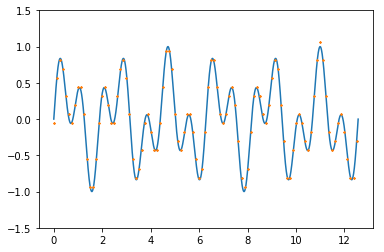

In [12]:
%matplotlib inline
plt.plot(t,x,'-',ts,xq,'*',ms=2)
plt.ylim([-1.5,1.5])
plt.show()

__Exemplo adicional:__ Versão audível com quantização

In [13]:
# 1. normaliza
lb = min(X)
ub = max(X)
XNORM = (X-lb)/(ub-lb)
# 2. quantiza
XQNORM = np.floor(16*XNORM)
XQ = (ub-lb)*XQNORM/16+lb+0.5*(ub-lb)/16

In [14]:
# toca sinal sonoro quantizado
ipd.Audio(XQ, rate=rate)

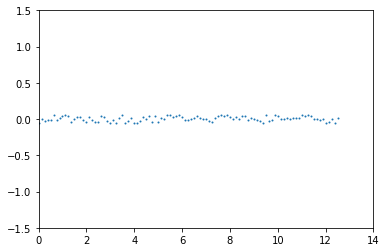

In [15]:
# Plota apenas o erro de quantização
%matplotlib inline
plt.plot(ts,xq-xs,'.',ms=2)
plt.axis([0, 14, -1.5, 1.5])
plt.show()

In [16]:
# toca apenas o erro de quantização
ipd.Audio(XQ-X, rate=rate)

### Figura 1.3: acréscimo de ruído aditivo

$$y_n = x_n+\varepsilon_n$$

In [17]:
# Sinal amostrado adicionado de ruído uniforme 
xr = xs + 0.5*(np.random.rand(len(xs))-0.5)

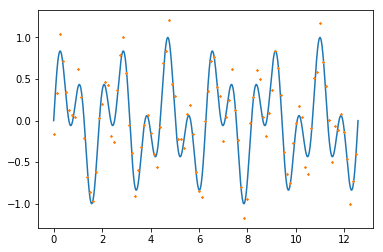

In [18]:
# Mostra o sinal original e o sinal amostrado c/ ruído
%matplotlib inline
plt.plot(t,x,'-',ts,xr,'*',ms=2)
plt.show()

__Exemplo adicional:__ Versão audível com ruído

In [19]:
# cria sinal ruidoso
R = 0.5*(np.random.rand(len(T))-0.5)

In [20]:
# toca sinal + ruído
ipd.Audio(X+R,rate=rate)
# toca apenas ruído
ipd.Audio(R,rate=rate)

## Sinais bidimensionais / imagens
> - modelados como funções de duas variáveis reais $(x,y)\in[a,b]\times[c,d]$ (costumam representar o _espaço_)
> - $f(x,y)\in\mathbb{R}$ pode representar luminosidade, cor, temperatura, densidade, etc.

### Figura 1.4: Uma imagem com 4 componentes senoidais

In [21]:
# Define um domínio espacial com 201x201 pontos no retângulo [0,1]x[0,1].
# Lembre-se que os índices crescentes da matriz refletem valores descrescentes do eixo vertical
density = 200
x = np.arange(0,1,1/density)
y = np.arange(1,0,-1/density)
x, y = np.meshgrid(x,y)

Calcula e plota o gráfico da função do exemplo da página 7:

$$ f = 1.5\cos(7y)\cos(2x)+ 0.75\sin(3y)\cos(5x) -1.3\cos(15y)\sin(9x) + 1.1\sin(11y)\sin(13x)$$

In [22]:
f = 1.5*np.cos(7*y)*np.cos(2*x)+ 0.75*np.sin(3*y)*np.cos(5*x) -1.3*np.cos(15*y)*np.sin(9*x) + 1.1*np.sin(11*y)*np.sin(13*x)

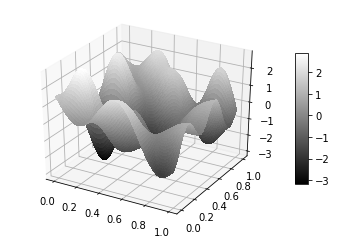

In [23]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
s = ax.plot_surface(x,y,f,rstride=2, cstride=2, cmap=matplotlib.cm.binary_r,
                       linewidth=0, antialiased=False)
fig.colorbar(s, shrink=0.6, aspect=10)

In [24]:
# Normaliza a função para o intervalo [0,1], para representar uma imagem em tons de cinza.
lb = np.min(np.min(f)) # lower bound da função
ub = np.max(np.max(f)) # upper bound
g = (f-lb)/(ub-lb)     # mapeia linearmente em [0,1]

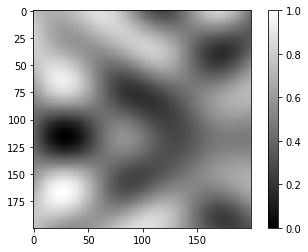

In [25]:
# Exibe a imagem codificada em tons de cinza na matriz
%matplotlib inline
plt.gray()
plt.imshow(g,interpolation='None')
plt.colorbar()
plt.show()

__Efeito da quantização usando B bits ($2^B$ valores distintos)__

Note como o aspecto da imagem parece "pixelizado", porém essas "bordas" acompanham as curvas de nível da função, não tendo relação com a densidade de pontos da matriz.

Experimente usar outros valores para o parâmetro B.

In [26]:
def pltimage(B=4):
    global gq
    gq = np.floor(2**B*g)/2**B+1/2**(B+1)
    %matplotlib inline
    plt.imshow(gq,interpolation='None')
    plt.show()

In [27]:
ipw.interact(pltimage, B=(1,8))

<function __main__.pltimage>

__Efeito da amostragem__

Supondo-se a imagem original contínua (uma função $f(x,y):[a,b]\times[c,d]\mapsto\mathbb{R}$), podemos definir taxas de amostragem $\Delta_x$ e $\Delta_y$ e discretizar o domínio da função obtendo uma matriz $\mathcal{M}\in\mathbb{R}^{(M+1)\times(N+1)}$ com entradas

$$\mathcal{M}_{m,n} = f(a+m\Delta_x,c+n\Delta_y),$$

para $m=0,1,\ldots,M=\frac{b-a}{\Delta_x}$ e $n=0,1,\ldots,N=\frac{d-c}{\Delta_y}$.

Outra estratégia de amostragem toma as amostras no meio dos retângulos de tamanho $\Delta_x\times\Delta_y$, obtendo $\bar{\mathcal{M}}\in\mathbb{R}^{M\times N}$ com entradas

$$\bar{\mathcal{M}}_{m,n} = f\left(a+\left(m+\frac{1}{2}\right)\Delta_x,b+\left(n+\frac{1}{2}\right)\Delta_y\right),$$

para $m=0,1,\ldots,M-1$ e $n=0,1,\ldots,N-1$.

In [28]:
# No exemplo a seguir a imagem é sub-amostrada preservando 1/N dos pontos originais do domínio da função
def pltsubsampledimage(N=4):
    global fs
    fs = g[0:g.shape[0]:N, 0:g.shape[1]:N]
    %matplotlib inline
    plt.imshow(fs,interpolation='None')
    plt.show()

In [29]:
ipw.interact(pltsubsampledimage, N=(1,20))

<function __main__.pltsubsampledimage>

### Figura 1.5: imagem original com ruído aditivo

In [30]:
gn = g + 0.1*(np.random.rand(g.shape[0],g.shape[1])-0.5)

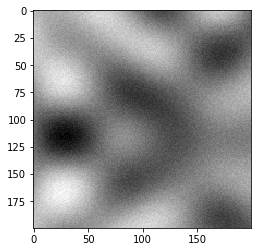

In [31]:
%matplotlib inline
plt.imshow(gn)
plt.show()

__Imagens coloridas:__ consistem em várias camadas $f_j(x,y)$ para cada canal de cor $j$.


In [32]:
M, N = 10, 10
C = [ np.random.randint(255,size=(M,N)) for i in range(3) ]
%matplotlib inline
for i in range(3):
    plt.subplot(1,4,i+1, aspect=0.5)
    plt.gray()
    plt.imshow(C[i], interpolation='none')
    plt.title(["R","G", "B"][i])
plt.subplot(1,4,4, aspect=0.5)
plt.imshow([[[C[i][m][n] for i in range(3)] for n in range(N)] for m in range(M)], interpolation='none')
plt.title("RGB")
plt.show()

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

# Seção 1.4: Modelos de espaços vetoriais para sinais e imagens

## Definição 1.4.1: espaço vetorial

### $V$ é um espaço vetorial sobre $\mathbb{R}$ (ou $\mathbb{C}$) se:

- $\forall u,v,\in V\quad\quad u+v\in V$
- $\forall u\in V\quad\forall\alpha\in\mathbb{R}|\mathbb{C}\quad\quad \alpha u\in V$
- $\forall u,v,w\in V\quad\forall\alpha,\beta\in\mathbb{R}|\mathbb{C}:$
> - comutatividade: $u+v = v+u$
> - associatividade: $(u+v)+w = u+(v+w)$
> - $\exists \mathbf{0}\in V$ tal que $u+\mathbf{0} = \mathbf{0}+u = u$
> - $1u = u$
> - $\forall u\in V\exists w\in V$ tal que $u+w = \mathbf{0}\quad (w=-u)$
> - $(\alpha\beta)u = \alpha(\beta u)$
> - distributividade(s): $(\alpha+\beta)u = \alpha u+\beta u$ e $\alpha(u+v) = \alpha u+\alpha v$

## Proposição 1.4.1 (exercício 1.12)

### Se $V$ é um espaço vetorial sobre $\mathbb{R}$ ou $\mathbb{C}$ então

> - $\mathbf{0}$ é único
> - $\forall u\in V\quad 0u = \mathbf{0}$
> - $\forall u\ \exists!w:\ u+w=\mathbf{0}$ (unicidade do inverso aditivo)

### Exemplo 1.1: $\mathbb{R}^N$ ou $\mathbb{C}^N$

$$\begin{array}{rcl}
x&=&(x_1,x_2,\ldots,x_n)\\
y&=&(y_1,y_2,\ldots,y_n)\\
x+y& = &(x_1+y_1,x_2+y_2,\ldots,x_n+y_n)\\
\alpha x& = &(\alpha x_1,\alpha x_2,\ldots,\alpha x_n)\\
\mathbf{0}&=&(0,0,\ldots,0)\\
-x&=&(-x_1,-x_2,\ldots,-x_n)
\end{array}$$

### Exemplo 1.1: $\mathbb{R}^{M\times N}$ ou $\mathbb{C}^{M\times N}$

$$\begin{array}{rclcrcl}
x&=&\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&x_{ij}&\cdots\\&\vdots&\ddots\end{array}\right]&&
y&=&\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&y_{ij}&\cdots\\&\vdots&\ddots\end{array}\right]\\
x+y& = &\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&x_{ij}+y_{ij}&\cdots\\&\vdots&\ddots\end{array}\right]&&
\alpha x& = &\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&\alpha x_{ij}&\cdots\\&\vdots&\ddots\end{array}\right]\\
\mathbf{0}&=&\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&0&\cdots\\&\vdots&\ddots\end{array}\right]&&
-x&=&\left[\begin{array}{ccc}\ddots&\vdots&\\\cdots&-x_{ij}&\cdots\\&\vdots&\ddots\end{array}\right]
\end{array}$$

### Exemplo 1.3: Sinais infinitos

$$\begin{array}{rcl}
x&=&(x_0,x_1,\ldots)\\
y&=&(y_0, y_1,\ldots)\\
x+y& = &(x_0+y_0,x_1+y_1,\ldots)\\
\alpha x& = &(\alpha x_0,\alpha x_1,\ldots)\\
\mathbf{0}&=&(0,0,\ldots)\\
-x&=&(-x_0,-x_1,\ldots)
\end{array}$$

### Sinais bi-infinitos

$$\begin{array}{rcl}
x&=&(\ldots,x_{-1},x_0,x_1,\ldots)\\
y&=&(\ldots,y_{-1},y_0, y_1,\ldots)\\
x+y& = &(\ldots,x_{-1}+y_{-1},x_0+y_0,x_1+y_1,\ldots)\\
\alpha x& = &(\ldots,\alpha x_{-1},\alpha x_0,\alpha x_1,\ldots)\\
\mathbf{0}&=&(\ldots,0,0,0,\ldots)\\
-x&=&(\ldots,-x_{-1},-x_0,-x_1,\ldots)
\end{array}$$

### Sinais limitados infinitos  ($L^\infty(\mathbb{N})$) ou bi-infinitos ($L^\infty(\mathbb{Z})$)

$$x\in L^\infty(\mathbb{N}|\mathbb{Z}) \iff \exists M_x: \forall k\in\mathbb{N}|\mathbb{Z}\quad|x_k|\le M_x$$

Note que

$$x,y\in L^\infty(\mathbb{N}|\mathbb{Z}) \implies x+y\in L^\infty(\mathbb{N}|\mathbb{Z})$$

pois

$$|x_k+y_k| \le |x_k|+|y_k| \le M_x+M_y\quad\mbox{(desigualdade triangular)}$$

### Sinais de energia limitada infinitos  ($L^2(\mathbb{N})$) ou bi-infinitos ($L^2(\mathbb{Z})$)

$$x\in L^2(\mathbb{N}|\mathbb{Z}) \iff \sum_{k\in\mathbb{N}|\mathbb{Z}}|x_k|^2<\infty$$

É possível provar (exercício 1.1) que

$$x,y\in L^2(\mathbb{N}|\mathbb{Z}) \implies x+y\in L^2(\mathbb{N}|\mathbb{Z})$$

### Observação: pularemos a seção 1.4.2 (espaços de funções)
### Quem tiver interesse pode ler em casa!

# Seção 1.5: Formas de onda básicas (caso analógico)

## Relação de Euler

$$e^{i\theta} = \cos(\theta)+i\mbox{sen}(\theta)$$

Pensando em $\theta$ como uma função linear do tempo ($\theta=\omega t$) temos:

$$e^{i\omega t} = \cos(\omega t)+i\mbox{sen}(\omega t)$$

Podemos representar várias funções $f(x)$ que nos interessam aqui,
como senos, cossenos e exponenciais,
através da série de Taylor $$f(x)=\sum_{n=0}^\infty a_nx^n.$$

Quando tal representação existe, podemos obter os coeficientes
$a_n$ calculando a função original e suas derivadas no ponto $x=0$:

$$\begin{array}{l}
f(0)=a_0\\
f'(x)=\sum_{n=1}^\infty na_nx^{n-1}\implies f'(0)=a_1\\
f''(x)=\sum_{n=2}^\infty n(n-1)a_nx^{n-2}\implies f''(0)=2a_2\implies a_2=\frac{f''(0)}{2}\\
\vdots\\
f^{(m)}(x)=\sum_{n=m}^\infty n(n-1)\cdots(n-m+1)a_nx^{n-m}\\
\quad\quad\implies
f^{(m)}(0)=m!a_m\implies a_m=\frac{f^{(m)}(0)}{m!}.\end{array}$$

$$\begin{array}{ll}
\mbox{sen}(x)&=\mbox{sen}(0)+\cos(0)x-\frac{\mbox{sen}(0)}{2}x^2-\frac{\cos(0)}{3!}x^3+\cdots\\
&=
\sum_{n=0}^\infty\frac{(-1)^nx^{2n+1}}{(2n+1)!}\\
\cos(x)&=\cos(0)-\mbox{sen}(0)x-\frac{\cos(0)}{2}x^2+\frac{\mbox{sen}(0)}{3!}x^3+\cdots\\
&=
\sum_{n=0}^\infty\frac{(-1)^nx^{2n}}{(2n)!}\\
e^x&=e^0+e^0x+\frac{e^0}{2}x^2+\frac{e^0}{3!}x^3+\cdots\\
&=\sum_{n=0}^\infty\frac{x^n}{n!}
\end{array}$$

Para $x=\omega t$, temos:

$$e^{i\omega t}=\sum_{n=0}^\infty\frac{(i\omega t)^n}{n!}
=\sum_{n=0}^\infty\frac{i^n(\omega t)^n}{n!}$$

Observe que para $n$ par temos $i^0,i^2,i^4,i^6,\ldots=1,-1,1,-1,\ldots$
e para $n$ ímpar temos $i^1,i^3,i^5,i^7,\ldots=i,-i,i,-i,\ldots$.

Assim obtemos a Relação de Euler: $e^{i\omega t} = \cos(\omega t)+i\mbox{sen}(\omega t)$.

Considerando

$$e^{i\omega t} = \cos(\omega t)+i\mbox{sen}(\omega t)$$

$$e^{-i\omega t} = \cos(\omega t)-i\mbox{sen}(\omega t)$$

podemos concluir que

$$\cos(\omega t) = \frac{e^{i\omega t}+e^{-i\omega t}}{2} = \mbox{Re}(e^{i\omega t})$$

$$\mbox{sen}(\omega t) = \frac{e^{i\omega t}-e^{-i\omega t}}{2i} = \mbox{Im}(e^{i\omega t})$$

### Frequência angular e período

- $\omega$ (em rad/seg) corresponde ao ângulo em radianos percorrido no intervalo $t\in[0,1]$

- o período $\lambda$ é o menor valor positivo tal que

$$e^{i\omega(t+\lambda)}=e^{i\omega t}\ \forall t\in\mathbb{R}$$

$$\lambda|\omega|=2\pi \implies \lambda = \frac{2\pi}{|\omega|}$$

### Motivação

Pode-se mostrar que qualquer função $x:[-T,T]\mapsto\mathbf{R}$ "razoável" (limitada e contínua por partes) pode ser escrita como

$$x(t) = \sum_{k=-\infty}^{\infty}c_ke^{i\omega_kt}$$

onde $\omega_k = k\pi/T$.

### Exemplo 1.10

Equivalência entre senos e cossenos e exponenciais complexas

Define duas funções equivalentes:

$$x_1(t) = \sin(t)+3\sin(-2t)-2\cos(-5t)$$

$$x_2(t) = \frac{e^{it}-e^{-it}}{2i}+
           \frac{-3e^{i2t}+3e^{-i2t}}{2i}-
           e^{i5t}+e^{-i5t}$$

In [33]:
rate = 200
t = np.arange(0,2*m.pi,1/rate)
x1 = np.sin(t)+3*np.sin(-2*t)-2*np.cos(-5*t)
x2 = (m.e**(1j*t)-m.e**(-1j*t))/(2*1j)+ \
     (-3*m.e**(2*1j*t)+3*m.e**(-2*1j*t))/(2*1j)- \
     (m.e**(5*1j*t)+m.e**(-5*1j*t))

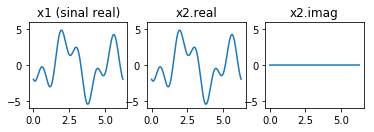

In [34]:
x = [x1, x2.real, x2.imag]
%matplotlib inline
for i in range(3):
    plt.subplot(1,3,i+1, aspect=0.5)
    plt.plot(t,x[i])
    plt.ylim([-6,6])
    plt.title(["x1 (sinal real)","x2.real","x2.imag"][i])
plt.show()

### Figura 1.6: visualizações de uma exponencial complexa

Define duas exponenciais complexas com frequências 0.5 rad/s e 2 rad/s:

$$f(t) = e^{i\frac{1}{2}t}$$

$$g(t) = e^{i2t}$$

In [35]:
rate = 200
dur = 10
t = np.linspace(0,dur,rate)
f = [m.e**(0.5*1j*t), m.e**(2*1j*t)]

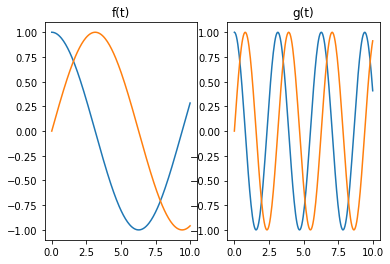

In [36]:
%matplotlib inline
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(t,f[i].real,t,f[i].imag)
    plt.title(["f(t)","g(t)"][i])
plt.show()

__Alternativa:__ plota os mesmos gráficos como funções de $\mathbb{R}$ em $\mathbb{C}$

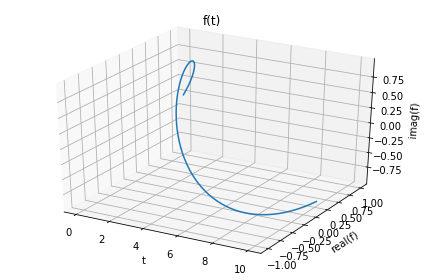

In [37]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
s = ax.plot3D(t,f[0].real,f[0].imag)
plt.title("f(t)")
ax.set_xlabel('t')
ax.set_ylabel('real(f)')
ax.set_zlabel('imag(f)')
plt.tight_layout()
plt.show()

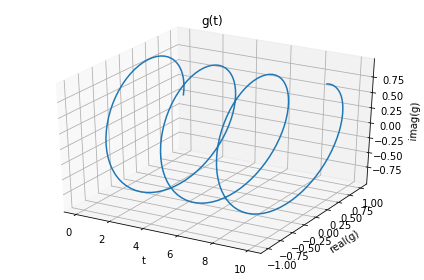

In [38]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
s = ax.plot3D(t,f[1].real,f[1].imag)
plt.title("g(t)")
ax.set_xlabel('t')
ax.set_ylabel('real(g)')
ax.set_zlabel('imag(g)')
plt.tight_layout()
plt.show()

__Alternativa:__ animação em $\mathbb{C}$ em função do tempo

<IPython.core.display.Javascript object>


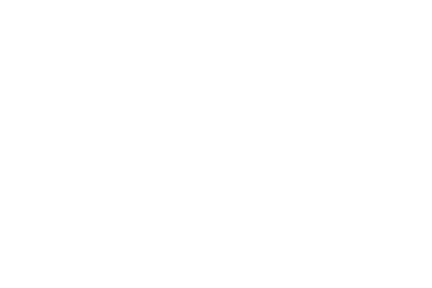

<IPython.core.display.Javascript object>


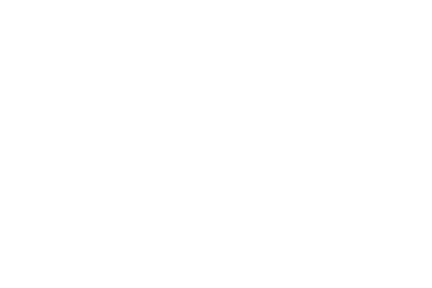

Traceback (most recent call last):
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [39]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
linef, = ax.plot([], [], 'o-', lw=2)
lineg, = ax.plot([], [], 'o-', color='red', lw=2)
# initialização: plota o fundo de cada quadro
def init():
    linef.set_data([], [])
    lineg.set_data([], [])
    return linef, lineg
# função de animação, chamada sequencialmente (i=índice do quadro)
def animate(i):
    z = [ f[j][i] for j in range(2) ]
    x = np.real(z)
    y = np.imag(z)
    linef.set_data([x[0],0], [y[0],0])
    lineg.set_data([x[1],0], [y[1],0])
# call the animator.  blit=True means only re-draw the parts that have changed.
fps = 20
imf = anim.FuncAnimation(fig, animate, init_func=init,
                               frames=dur*fps, interval=1000.0/fps, blit=True)
plt.show()
plt.legend(['$e^{i0.5t}$', '$e^{i2t}$'])
# se quiser salvar em arquivo:
#imf.save('anim_2exp.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

### Novo exemplo: 3 componentes senoidais complexas e sua soma

$$e_1(t)=e^{i2\pi 0.2t}$$

$$e_2(t)=\frac{1}{2}e^{-i2\pi t}$$

$$e_3(t)=\frac{1}{4}e^{i2\pi 3.8t}$$

$$e_4(t)=\sum_{i=1}^3 e_i(t)$$


In [40]:
e = [m.e**(1j*2*np.pi*0.2*t),
     0.5*m.e**(1j*2*np.pi*(-1)*t),
     0.25*m.e**(1j*2*np.pi*3.8*t),
     m.e**(1j*2*np.pi*0.2*t)+0.5*m.e**(1j*2*np.pi*(-1)*t)+0.25*m.e**(1j*2*np.pi*3.8*t)]
l = ["$e_1(t)=e^{i2\pi 0.2t}$",
     "$e_2(t)=0.5e^{-i2\pi t}$",
     "$e_3(t)=0.25e^{i2\pi 3.8t}$",
     "$e_4(t)=\sum e_i(t)$"]

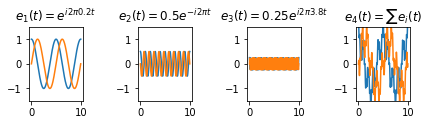

In [41]:
%matplotlib inline
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1,aspect=5)
    plt.plot(t,e[i].real,t,e[i].imag)
    plt.ylim([-1.5,1.5])
    plt.title(l[i])
    plt.tight_layout()

plt.show()

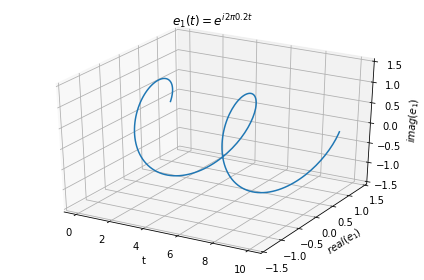

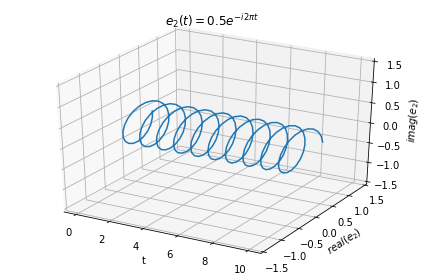

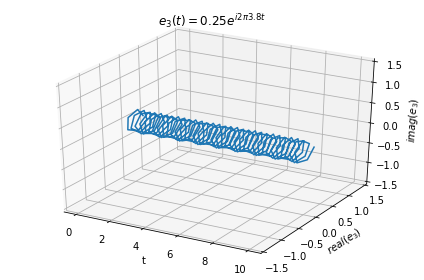

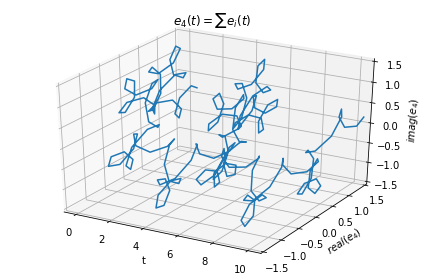

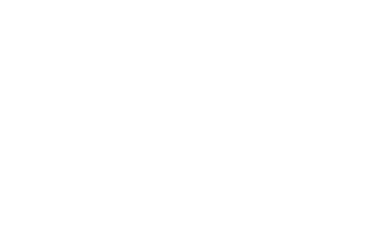

In [42]:
for i in range(4):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    s = ax.plot3D(t,e[i].real,e[i].imag)
    plt.title(l[i])
    ax.set_xlabel('t')
    ax.set_ylabel('$real(e_'+str(i+1)+')$')
    ax.set_ylim3d([-1.5,1.5])
    ax.set_zlabel('$imag(e_'+str(i+1)+')$')
    ax.set_zlim3d([-1.5,1.5])
    plt.tight_layout()

fig = plt.figure()
plt.plot()
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


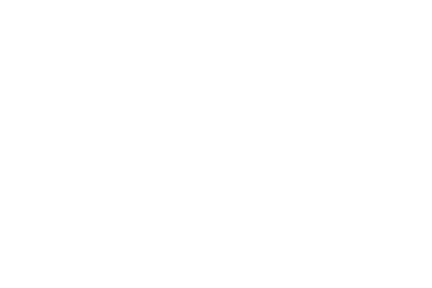

<IPython.core.display.Javascript object>


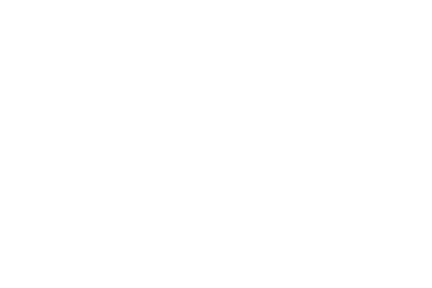

Traceback (most recent call last):
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [43]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
line = [[]]*4
for j in range(4):
    line[j], = ax.plot([], [], 'o-', lw=2)
# initialização: plota o fundo de cada quadro
def init():
    for j in range(4):
        line[j].set_data([], [])
    return line
# função de animação, chamada sequencialmente (i=índice do quadro)
def animate(i):
    z = [ e[j][i] for j in range(4) ]
    x = np.real(z)
    y = np.imag(z)
    for j in range(4):
        line[j].set_data([x[j],0], [y[j],0])
# call the animator.  blit=True means only re-draw the parts that have changed.
fps = 20
imf = anim.FuncAnimation(fig, animate, init_func=init,
                               frames=dur*fps, interval=1000.0/fps, blit=True)
plt.show()
plt.legend(['$e_1(t)$', '$e_2(t)$', '$e_3(t)$', '$e_4(t)$'])
# se quiser salvar em arquivo:
#imf.save('anim_4exp.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

## Funções básicas exponenciais de duas variáveis

$$e^{i(\alpha x+\beta y)} = \cos(\alpha x+\beta y)+i\sin(\alpha x+\beta y)$$

Mas também vale que

$$e^{i(\alpha x+\beta y)} = e^{i\alpha x}e^{i\beta y}$$

Logo

$$\begin{array}{rl}
e^{i(\alpha x+\beta y)} = &\cos(\alpha x)\cos(\beta y)-\sin(\alpha x)\sin(\beta y)\\
&+i(\cos(\alpha x)\sin(\beta y)+\sin(\alpha x)\cos(\beta y))
\end{array}$$

(Observem como as identidades trigonométricas com somas de ângulos saem trivialmente!)

## Figura 1.7: Exemplos de exponenciais complexas em 2D

$$e^{i(\alpha x+\beta y)} = e^{i2\pi(px+qy)}$$

In [44]:
# Define todos os pares (p,q) ilustrados na figura 1.7
PQ = [(10, 0), (0, 10), (30, 8), (5, 10)]
# Define domínios espaciais (horizontal e vertical)
# usando as frequências p e q (em Hz)
density = 200
x = np.arange(0,1,1/density)
y = np.arange(1,0,-1/density)
x, y = np.meshgrid(x,y)

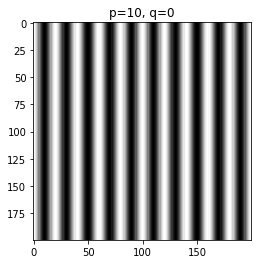

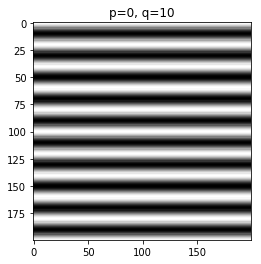

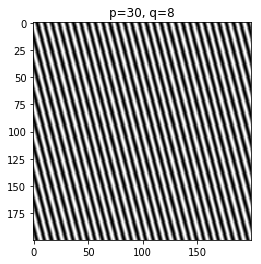

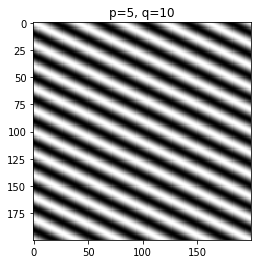

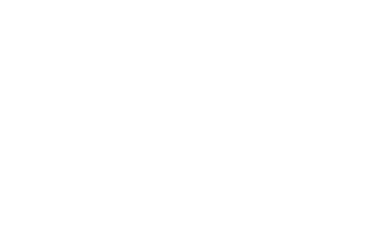

In [45]:
# Percorre os 4 cenários
%matplotlib inline
for j in range(4):
    p,q=PQ[j]
    # Define a exponencial complexa no plano xy
    f = m.e**(2*m.pi*1j*q*y)*m.e**(2*m.pi*1j*p*x)
    # Corrige a escala para [0,1]
    plt.figure()
    plt.gray()
    plt.imshow(0.5*(f.real+1))
    plt.title("p={0}, q={1}".format(p,q))

fig = plt.figure()
plt.plot()
plt.axis('off')
plt.show()

# Seção 1.6: Amostragem e aliasing

## Dependência do sinal em relação à taxa de amostragem

## Figura 1.8: Exemplo simples de sinal 1D amostrado a 20Hz ($\Delta_t=0.05$)

$$f(t) = \sin(\omega t)$$

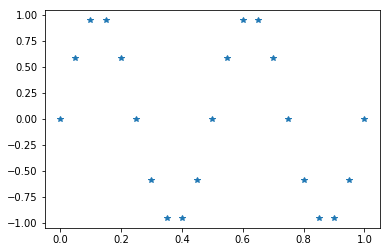

In [46]:
%matplotlib inline
t = np.linspace(0,1,21)
x = np.sin(44*m.pi*t)
plt.plot(t,x,"*")

## Figura 1.9: A mesma função anterior, amostrada a 200Hz ($\Delta_t=0.005$)

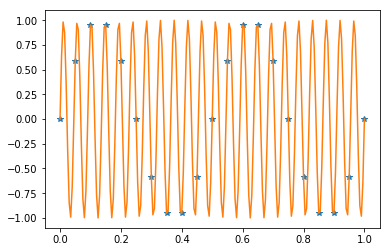

In [47]:
%matplotlib inline
t = np.linspace(0,1,21)
x = np.sin(44*m.pi*t)
t2 = np.linspace(0,1,201)
x2 = np.sin(44*m.pi*t2)
plt.plot(t,x,"*",t2,x2)

## O problema: existem valores de $p$ e $q$ tais que

$$\Large\mathbf{e^{i2\pi p\frac{n}{N}} = e^{i2\pi q\frac{n}{N}}, \forall n\in\mathbb{Z}}$$

Basta valer que

$$1=e^{i2\pi p\frac{n}{N}}/e^{i2\pi q\frac{n}{N}}=e^{i2\pi (p-q)\frac{n}{N}}, \forall n\in\mathbb{Z}$$

ou seja, basta que exista $k\in\mathbb{Z}$ tal que

$$p-q = kN$$

Assim todas as exponenciais com frequências

$$q=\ldots,p-3q,p-2q,p-q,p,p+q,p+2q,p+3q\ldots$$

gerarão a mesma lista de amostras que aquela com frequência $p$.

### Aliasing para senos e cossenos

A equação $e^{i2\pi p\frac{n}{N}} = e^{i2\pi q\frac{n}{N}}, \forall n\in\mathbb{Z}$ implica imediatamente em:

$$\sin(2\pi p\frac{n}{N}) = \sin(2\pi q\frac{n}{N}), \forall n\in\mathbb{Z}$$

e

$$\cos(2\pi p\frac{n}{N}) = \cos(2\pi q\frac{n}{N}), \forall n\in\mathbb{Z}$$

Mais ainda, no caso real basta se considerar $0\le p,q\le \frac{N}{2}$.

### Aliasing traz duas implicações importantes:

> - implicação física: ao se amostrar um sinal analógico, perde-se a capacidade de discernir frequências separadas por múltiplos de $N$; isso gera a necessidade de filtros passa-baixas

> - implicação matemática: para se analisar um sinal a $N$ Hz, basta considerar frequências na faixa $<-\frac{N}{2}<q\le \frac{N}{2}$.

## Figura 1.10: Exemplo de aliasing espacial
### A mesma função 

$$f(x,y)=256\sin(2\pi(50x+70y))$$

### é amostrada em grids de 60x60, 100x100, 300x300 e 1000x1000

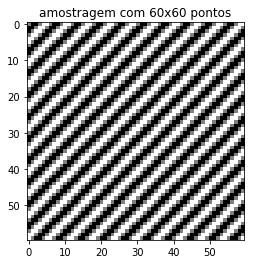

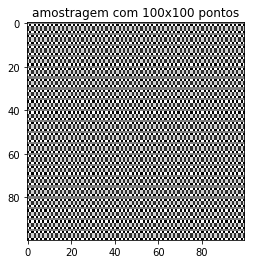

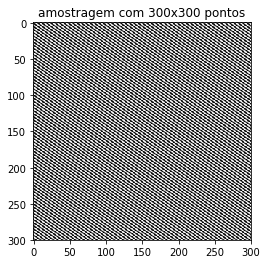

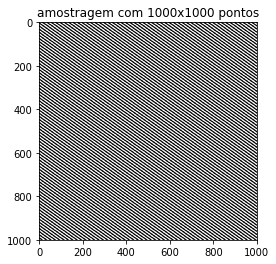

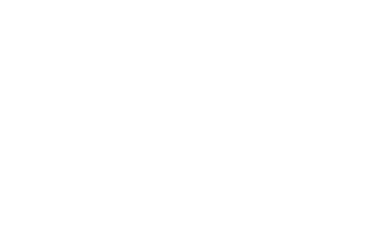

In [48]:
%matplotlib inline
N=[60, 100, 300, 1000]
for j in range(4):
    density = N[j]
    x = np.arange(0,1,1/density)
    y = np.arange(1,0,-1/density)
    x, y = np.meshgrid(x,y)
    f = m.e**(2*m.pi*1j*70*y)*m.e**(2*m.pi*1j*50*x)
    plt.figure()
    plt.gray()
    plt.imshow(0.5*(f.imag)+1)
    plt.title("amostragem com {0}x{1} pontos".format(N[j],N[j]))

fig = plt.figure()
plt.plot()
plt.axis('off')
plt.show()

### Alternativa: mostra a variação do tamanho do grid de 10 em 10

<IPython.core.display.Javascript object>


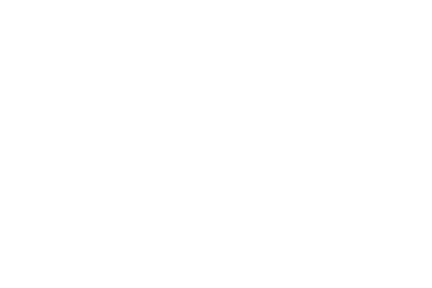

<IPython.core.display.Javascript object>


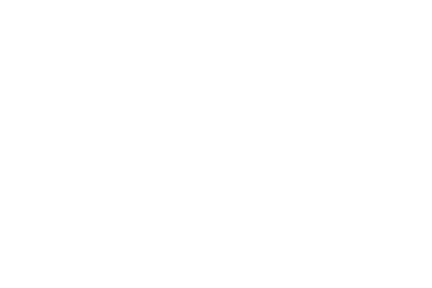

Traceback (most recent call last):
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/nicolas/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [50]:
%matplotlib notebook
plt.ion()
fig = plt.figure()
plt.gray()
density = 500
x = np.arange(0,1,1/density)
y = np.arange(1,0,-1/density)
x, y = np.meshgrid(x,y)
ims = []
for N in np.arange(50,500,10):
    f = m.e**(2*m.pi*1j*70*np.round(y*N)/N)*m.e**(2*m.pi*1j*50*np.round(x*N)/N)
    im = plt.imshow(0.5*(f.imag)+1)
    plt.axis('off')
    ims.append([im])
    
imf = anim.ArtistAnimation(fig, ims, interval=250, blit=True)

plt.show()
# se quiser salvar em arquivo:
#imf.save('anim_aliasing.mp4', fps=4, extra_args=['-vcodec', 'libx264'])